In [1]:
import os, time
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
now = int(time.time())

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
torch.cuda.is_available()

True

In [7]:
device_ids = [0]

In [8]:
batch_size = 128
num_epochs = 100

z_dimension = 100
num_feature = (32, 4, 4) # 64 * 64

img_shape = (1, 32, 32)

In [9]:
img_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
#     transforms.Normalize((.5, .5, .5), (.5, .5, .5))
#     transforms.Normalize((0.1307,), (0.3081,))
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST('~/data/mnist', transform=img_transform) #, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [10]:
class SelfAttention(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super(SelfAttention,self).__init__()
        
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
        
    def forward(self, x):
        
        m_batchsize, C, width ,height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1) # B (N) C
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height) # B C (N)
        energy = torch.bmm(proj_query, proj_key) # transpose check
        attention = self.softmax(energy) # B (N) (N) 
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height) # B C N

        out = torch.bmm(proj_value, attention.permute(0, 2, 1)) # B C N
        out = out.view(m_batchsize, C, width, height) # B C W H
        
        out = self.gamma * out + x
        return out, attention

In [11]:
def gen_noise(batch_size, label):
    prefix = np.zeros((batch_size, 10))
    prefix[np.arange(batch_size), label.cpu().numpy()] = 1
    z = np.random.normal(0, .3, (batch_size, z_dimension))
#     prefix = prefix / np.linalg.norm(prefix)
    z[:, :10] = prefix
    return torch.from_numpy(z).float().reshape(batch_size, z_dimension, 1, 1).to(device)

In [12]:
def gen_label_one_hot(batch_size, label):
    prefix = np.zeros((batch_size, 10))
    prefix[np.arange(batch_size), label.cpu().numpy()] = 1
    return torch.from_numpy(prefix).float().to(device)

In [13]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
        
# #         self.label_embedding = nn.Linear(10, np.prod(img_shape))
        
#         self.conv1 = nn.Sequential(
#             nn.utils.spectral_norm(nn.Conv2d(1, 32, 3, padding=1, stride=2)),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(.2, True),
# #             nn.AvgPool2d(2, 2), 
#         ) # b 16 16 16
        
#         self.conv2 = nn.Sequential(
#             nn.utils.spectral_norm(nn.Conv2d(32, 64, 3, padding=1, stride=2)),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(.2, True),
# #             nn.AvgPool2d(2, 2), 
#         ) # b 32 8 8
        
#         self.conv3 = nn.Sequential(
#             nn.utils.spectral_norm(nn.Conv2d(64, 128, 3, padding=1, stride=2)),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(.2, True),
# #             nn.AvgPool2d(2, 2), 
#         ) # b 64 4 4
        
#         self.conv4 = nn.Sequential(
#             nn.utils.spectral_norm(nn.Conv2d(128, 256, 3, padding=1, stride=2)),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(.2, True),
# #             nn.AvgPool2d(2, 2), 
#         ) # b 128 2 2
        
#         self.fc = nn.Sequential(
#             nn.Linear(256 * 2 * 2, 1024),
#             nn.LeakyReLU(.2, True),
#             nn.Linear(1024, 1),
#             nn.Sigmoid(),
# #             nn.Tanh(),
#         ) # b 1
        
#         self.label = nn.Sequential(
#             nn.Linear(256 * 2 * 2, 10),
#             nn.Sigmoid(),
# #             nn.Tanh(),
#         )
        
#         self.att1 = SelfAttention(128)
#         self.att2 = SelfAttention(256)

#     def forward(self, imgs): # b 1 32 32
        
# #         _imgs = torch.cat((imgs, self.label_embedding(labels.reshape([imgs.size(0), -1])).reshape(imgs.size(0), *img_shape)), 1)

#         outs = self.conv1(imgs)
#         outs = self.conv2(outs)
#         outs = self.conv3(outs)
#         outs, p1 = self.att1(outs)
#         outs = self.conv4(outs)
# #         outs, p1 = self.att2(outs)
#         outs = outs.view(imgs.size(0), -1)
#         img = self.fc(outs)
#         lab = self.label(outs)
        
#         return img, lab # b 1 1 1, b 10


class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__() # b d 32 32
        
        self.conv1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(1, d, 4, 2, 1)),
            nn.BatchNorm2d(d),
            nn.LeakyReLU(.2, True),
        ) # d 16 16
        
        self.conv2 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(d, d*2, 4, 2, 1)),
            nn.BatchNorm2d(d*2),
            nn.LeakyReLU(.2, True),
        ) # d*2 8 8
        
        self.conv3 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(d*2, d*4, 4, 2, 1)),
            nn.BatchNorm2d(d*4),
            nn.LeakyReLU(.2, True),
        ) # d*4 4 4
        
#         self.conv1 = nn.Conv2d(1, d, 4, 2, 1) # d 16 16
#         self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1) # d*2 8 8
#         self.conv2_bn = nn.BatchNorm2d(d*2)
#         self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1) # d*4 4 4
#         self.conv3_bn = nn.BatchNorm2d(d*4)
        
        
        self.output = nn.Sequential(
            nn.Conv2d(d*4, 1, 4, 2, 0),
            nn.Sigmoid(),
        ) # 1 1 1
        
        self.fc = nn.Sequential(
            nn.Linear(d * 4 * 4 * 4, 10),
            nn.Sigmoid(),
        ) # b 10
        
        self.att1 = SelfAttention(d)
#         self.att2 = SelfAttention(d*2)
#         self.att3 = SelfAttention(d*4)
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x): # b 1 32 32
        outs = self.conv1(x)
        outs, p1 = self.att1(outs)
        outs = self.conv2(outs)
#         outs, p1 = self.att2(outs)
        outs = self.conv3(outs)
#         outs, p1 = self.att3(outs)

        img = torch.sigmoid(self.output(outs)) # F.sigmoid
        con = self.fc(outs.view(x.size(0), -1))
        
        return img, con

In [14]:
# class Generator(nn.Module):
#     def __init__(self, inp_dim, num_feature):
#         super(Generator, self).__init__()

# #         self.label_emb = nn.Linear(10, 10)
        
#         self.fc = nn.Sequential(
#             nn.Linear(inp_dim, np.prod(num_feature)),
# #             nn.Sigmoid(),
#         ) # b *num_feature  b 32 4 4
        
#         self.upsample1 = nn.Sequential(
# #             nn.BatchNorm2d(128),
#             nn.utils.spectral_norm(nn.ConvTranspose2d(32, 64, 4, 2, 1)),
# #             nn.functional.interpolate(scale_factor=2),
# #             nn.Upsample(scale_factor=2),
# #             nn.Conv2d(32, 16, 3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(.2, True),
# #             nn.ReLU(True),
#         ) # b 16 8 8
        
#         self.upsample2 = nn.Sequential(
# #             nn.functional.interpolate(scale_factor=2),
#             nn.utils.spectral_norm(nn.ConvTranspose2d(64, 32, 4, 2, 1)),
# #             nn.Upsample(scale_factor=2),
# #             nn.Conv2d(16, 8, 3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(.2, True),
# #             nn.ReLU(True),
#         ) # b 8 16 16
        
#         self.upsample3 = nn.Sequential(
#             nn.utils.spectral_norm(nn.ConvTranspose2d(32, 16, 4, 2, 1)),
# #             nn.functional.interpolate(scale_factor=2),
# #             nn.Upsample(scale_factor=2),
# #             nn.Conv2d(8, 4, 3, padding=1, stride=1),
#             nn.BatchNorm2d(16),
#             nn.LeakyReLU(.2, True),
# #             nn.ReLU(True),
#         ) # b 4 32 32
        
#         self.conv = nn.Sequential(
# #             nn.functional.interpolate(scale_factor=2),
#             nn.utils.spectral_norm(nn.Conv2d(16, 1, 3, padding=1, stride=1)),
#             nn.Tanh(),
#         ) # b 1 32 32
        
#         self.att1 = SelfAttention(32)
#         self.att2 = SelfAttention(16)
        
        

#     def forward(self, noise):
        
# #         gen_input = torch.cat((labels.reshape(noise.size(0), -1), noise), -1)
# #         gen_input = torch.cat((self.label_emb(labels.reshape([noise.size(0), -1])), noise), -1)
        
#         outs = self.fc(noise)
#         outs = outs.view(noise.size(0), *num_feature)
#         outs = self.upsample1(outs)
#         outs = self.upsample2(outs)
#         outs, p1 = self.att1(outs)
#         outs = self.upsample3(outs)
# #         outs, p1 = self.att2(outs)
        
#         outs = self.conv(outs)
        
#         return outs


class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        
        self.deconv1 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dimension, d*4, 4, 2, 0)),
            nn.BatchNorm2d(d*4),
            nn.ReLU(True),
        ) # b d*4 4 4
        
        self.deconv2 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)),
            nn.BatchNorm2d(d*2),
            nn.ReLU(True),
        ) # b d*2 8 8
        
        self.deconv3 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(d*2, d, 4, 2, 1)),
            nn.BatchNorm2d(d),
            nn.ReLU(True),
        ) # b d 16 16
        
#         self.deconv1 = nn.ConvTranspose2d(z_dimension, d*4, 4, 2, 0) # b d*8 2 2
#         self.deconv1_bn = nn.BatchNorm2d(d*4)
#         self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1) # b d*2 4 4
#         self.deconv2_bn = nn.BatchNorm2d(d*2)
#         self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1) # b d 8 8
#         self.deconv3_bn = nn.BatchNorm2d(d)
        
        
        self.output = nn.Sequential(
            nn.ConvTranspose2d(d, 1, 4, 2, 1),
            nn.Tanh(),
        ) # b 1 32 32
        
#         self.att1 = SelfAttention(d*4)
#         self.att2 = SelfAttention(d*2)
        self.att3 = SelfAttention(d)
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x): # b 100 1 1
        outs = self.deconv1(x)
#         outs, p1 = self.att1(outs)
        outs = self.deconv2(outs)
#         outs, p1 = self.att2(outs)
        outs = self.deconv3(outs)
        outs, p1 = self.att3(outs)
        
        outs = self.output(outs)

        return outs

In [15]:
D = Discriminator(128).to(device)
G = Generator(128).to(device)

D = nn.DataParallel(D, device_ids=device_ids).to(device)
G = nn.DataParallel(G, device_ids=device_ids).to(device)

adversarial_loss = nn.MSELoss()
auxiliary_loss = nn.CrossEntropyLoss()

D_optimezer = optim.Adam(D.parameters(), lr=2e-4, betas=(0, 0.9))
G_optimezer = optim.Adam(G.parameters(), lr=2e-4, betas=(0, 0.9))

In [16]:
condition = torch.from_numpy(np.arange(10)).cuda()

In [17]:
writer = SummaryWriter(os.path.join('./log/cnn_cgan_self_attention', str(now)))

In [18]:
img_path = os.path.join("save_images/cnn_cgan_self_attention", str(now))
if not os.path.exists(img_path): os.makedirs(img_path)

In [19]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    _step = epoch * total_count
    
    d_loss_total = .0
    g_loss_total = .0
    for i, (imgs, labels) in enumerate(dataloader):
        
        real_imgs = imgs.cuda()
        real_labels = labels.cuda()
        
        real = torch.ones(imgs.size(0), 1).cuda()
        fake = torch.zeros(imgs.size(0), 1).cuda()
        
        fake_labels = torch.from_numpy(np.random.randint(0, 10, imgs.size(0))).cuda()
        z = gen_noise(imgs.size(0), fake_labels)
        
        ########## G ##########
        fake_imgs = G(z)
        fake_out, fake_out_labels = D(fake_imgs)
        
        g_loss = adversarial_loss(fake_out.view(imgs.size(0), 1), real) + auxiliary_loss(fake_out_labels, fake_labels)
        
        G_optimezer.zero_grad()
        g_loss.backward()
        G_optimezer.step()
        #######################
        
        ########## D ##########
        real_out, real_out_label = D(real_imgs)
        d_loss_real = adversarial_loss(real_out.view(imgs.size(0), 1), real_labels.float().view(imgs.size(0), 1))
        d_loss_real_label = auxiliary_loss(real_out_label, real_labels)
        real_scores = real_out
        
        fake_out, fake_out_labels = D(fake_imgs.detach())
        d_loss_fake = adversarial_loss(fake_out.view(imgs.size(0), 1), fake)
        d_loss_fake_label = auxiliary_loss(fake_out_labels, fake_labels)
        fake_scores = fake_out
        
        d_loss = (d_loss_real + d_loss_fake) / 2 + d_loss_real_label - d_loss_fake_label
        D_optimezer.zero_grad()
        d_loss.backward()
        D_optimezer.step()
        #######################
        
        d_loss_total += d_loss.item() * imgs.size(0)
        g_loss_total += g_loss.item() * imgs.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
        
        if (i + 1) % 300 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, g_loss, real_scores.mean(), fake_scores.mean()))
    
    setp = (epoch + 1) * total_count
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    
    tqdm.write("Finish Epoch [{}/{}], Mean D Loss: {:.6f}, Mean G Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total, ))
    
    if epoch == 0:
        real_images = real_imgs.view(-1, 1, 32, 32).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))
    
    condition_noise = gen_noise(condition.shape[0], condition)
    condition_images = G(condition_noise)
    
    writer.add_image('Generator Image', make_grid(fake_imgs.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    writer.add_image('Condition Generator Image', make_grid(condition_images.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    
    fake_images = fake_imgs.view(-1, 1, 32, 32).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{}.png'.format(epoch+1)))
    save_image(condition_images, os.path.join(img_path, 'condition_images-{}.png'.format(epoch+1)))

Epoch [1/100], Step:  38400, d_loss: 9.755344, g_loss: 2.656614, real_scores: 0.693999, fake_scores: 0.668387
Finish Epoch [1/100], D Loss: 1347.842622, G Loss: 327.724140
Epoch [2/100], Step:  38400, d_loss: 9.368597, g_loss: 2.288966, real_scores: 0.708189, fake_scores: 0.704836
Finish Epoch [2/100], D Loss: 685.852835, G Loss: 159.086436
Epoch [3/100], Step:  38400, d_loss: 11.519994, g_loss: 2.744350, real_scores: 0.711118, fake_scores: 0.621982
Finish Epoch [3/100], D Loss: 454.123653, G Loss: 112.979136
Epoch [4/100], Step:  38400, d_loss: 8.742670, g_loss: 2.886662, real_scores: 0.698946, fake_scores: 0.505592
Finish Epoch [4/100], D Loss: 334.329773, G Loss: 86.073629
Epoch [5/100], Step:  38400, d_loss: 8.551708, g_loss: 2.673651, real_scores: 0.705791, fake_scores: 0.500013
Finish Epoch [5/100], D Loss: 265.838673, G Loss: 66.827299
Epoch [6/100], Step:  38400, d_loss: 10.213568, g_loss: 2.725263, real_scores: 0.713735, fake_scores: 0.504141
Finish Epoch [6/100], D Loss: 220.

KeyboardInterrupt: 

In [22]:
writer.close()

In [24]:
torch.save(D.state_dict(), './ser/cnn_cgan_3_self_attention_discriminator.pt')
torch.save(G.state_dict(), './ser/cnn_cgan_3_self_attention_generator.pt')

In [24]:
D.load_state_dict(torch.load('./ser/cnn_cgan_3_self_attention_discriminator.pt'))
G.load_state_dict(torch.load('./ser/cnn_cgan_3_self_attention_generator.pt'))

tensor([5, 0, 6, 9, 4, 0, 1, 1, 7, 2, 3, 2, 9, 2, 8, 4], device='cuda:0')


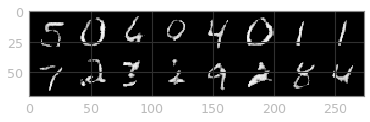

In [25]:
fake_labels = torch.from_numpy(np.random.randint(0, 10, 16)).cuda()
z = gen_noise(16, fake_labels)
print(fake_labels)
images = G(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()